# Amazon apparel Recommendation System

In [1]:
#import all the necessary packages.

from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

In [2]:
# in this project, we only choose the specific product like woman appreal because amazon consist 183k or 1.8 lakh product 
# hence duet to huge datas set we choose specific product for recommandation

# we have give a json file which consists of all information about the products
# loading the data using pandas' read_json file.
data = pd.read_json('tops_fashion.json')


In [3]:
print('number of data points:',data.shape[0])
print('number of features/variable',data.shape[1])

number of data points: 183138
number of features/variable 19


# EDA 

### Terminology:
What is a dataset? <br>
Rows and columns <br>
Data-point <br>
Feature/variable <br>







In [4]:
# each product/item has 19 features in the raw dataset.
data.columns # prints column-names or feature-names.

Index(['sku', 'asin', 'product_type_name', 'formatted_price', 'author',
       'color', 'brand', 'publisher', 'availability', 'reviews',
       'large_image_url', 'availability_type', 'small_image_url',
       'editorial_review', 'title', 'model', 'medium_image_url',
       'manufacturer', 'editorial_reivew'],
      dtype='object')

Of these 19 features, we will be using only 6 features in this project.
    1. asin  ( Amazon standard identification number)
    2. brand ( brand to which the product belongs to )
    3. color ( Color information of apparel, it can contain many colors as   a value ex: red and black stripes ) 
    4. product_type_name (type of the apperal, ex: SHIRT/TSHIRT )
    5. medium_image_url  ( url of the image )
    6. title (title of the product.)
    7. formatted_price (price of the product)

In [5]:
data = data[['asin', 'brand', 'color', 'medium_image_url', 'product_type_name', 'title', 'formatted_price']]

In [6]:
print ('Number of data points : ', data.shape[0], \
       'Number of features:', data.shape[1])
data.head() # prints the top rows in the table.

Number of data points :  183138 Number of features: 7


,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
0,B016I2TS4W,FNC7C,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,Minions Como Superheroes Ironman Long Sleeve R...,None
1,B01N49AI08,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Izo Tunic,None
2,B01JDPCOHO,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Won Top,None
3,B01N19U5H5,Focal18,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,Focal18 Sailor Collar Bubble Sleeve Blouse Shi...,None
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,Featherlite Ladies' Long Sleeve Stain Resistan...,$26.26


### Missing data for various features.

####  Basic stats for the feature: product_type_name

In [7]:
# We have total 72 unique type of product_type_names
print(data['product_type_name'].describe())

# 91.62% (167794/183138) of the products are shirts,


count     183138
unique        72
top        SHIRT
freq      167794
Name: product_type_name, dtype: object


In [8]:
# names of different product types
print(data['product_type_name'].unique())

['SHIRT' 'SWEATER' 'APPAREL' 'OUTDOOR_RECREATION_PRODUCT'
 'BOOKS_1973_AND_LATER' 'PANTS' 'HAT' 'SPORTING_GOODS' 'DRESS' 'UNDERWEAR'
 'SKIRT' 'OUTERWEAR' 'BRA' 'ACCESSORY' 'ART_SUPPLIES' 'SLEEPWEAR'
 'ORCA_SHIRT' 'HANDBAG' 'PET_SUPPLIES' 'SHOES' 'KITCHEN' 'ADULT_COSTUME'
 'HOME_BED_AND_BATH' 'MISC_OTHER' 'BLAZER' 'HEALTH_PERSONAL_CARE'
 'TOYS_AND_GAMES' 'SWIMWEAR' 'CONSUMER_ELECTRONICS' 'SHORTS' 'HOME'
 'AUTO_PART' 'OFFICE_PRODUCTS' 'ETHNIC_WEAR' 'BEAUTY'
 'INSTRUMENT_PARTS_AND_ACCESSORIES' 'POWERSPORTS_PROTECTIVE_GEAR' 'SHIRTS'
 'ABIS_APPAREL' 'AUTO_ACCESSORY' 'NONAPPARELMISC' 'TOOLS' 'BABY_PRODUCT'
 'SOCKSHOSIERY' 'POWERSPORTS_RIDING_SHIRT' 'EYEWEAR' 'SUIT'
 'OUTDOOR_LIVING' 'POWERSPORTS_RIDING_JACKET' 'HARDWARE' 'SAFETY_SUPPLY'
 'ABIS_DVD' 'VIDEO_DVD' 'GOLF_CLUB' 'MUSIC_POPULAR_VINYL'
 'HOME_FURNITURE_AND_DECOR' 'TABLET_COMPUTER' 'GUILD_ACCESSORIES'
 'ABIS_SPORTS' 'ART_AND_CRAFT_SUPPLY' 'BAG' 'MECHANICAL_COMPONENTS'
 'SOUND_AND_RECORDING_EQUIPMENT' 'COMPUTER_COMPONENT' 'JEWELRY'
 'B

In [9]:
# find the 10 most frequent product_type_names.
product_type_count = Counter(list(data['product_type_name']))
product_type_count.most_common(10)

[('SHIRT', 167794),
 ('APPAREL', 3549),
 ('BOOKS_1973_AND_LATER', 3336),
 ('DRESS', 1584),
 ('SPORTING_GOODS', 1281),
 ('SWEATER', 837),
 ('OUTERWEAR', 796),
 ('OUTDOOR_RECREATION_PRODUCT', 729),
 ('ACCESSORY', 636),
 ('UNDERWEAR', 425)]

####  Basic stats for the feature: brand

In [10]:
print(data['brand'])

0                 FNC7C
1          FIG Clothing
2          FIG Clothing
3               Focal18
4           FeatherLite
              ...      
183133        TOOGOO(R)
183134       VOGUE CODE
183135         Wrangler
183136    susana monaco
183137         Sexybaby
Name: brand, Length: 183138, dtype: object


In [11]:
# there are 10577 unique brands
print(data['brand'].describe())

# 183138 - 182987 = 151 missing values.

count     182987
unique     10577
top         Zago
freq         223
Name: brand, dtype: object


In [12]:
brand_count = Counter(list(data['brand']))
brand_count.most_common(10)

[('Zago', 223),
 ('XQS', 222),
 ('Yayun', 215),
 ('YUNY', 198),
 ('XiaoTianXin-women clothes', 193),
 ('Generic', 192),
 ('Boohoo', 190),
 ('Alion', 188),
 ('Abetteric', 187),
 ('TheMogan', 187)]

####  Basic stats for the feature: color

In [13]:

print(data['color'].describe())


# we have 7380 unique colors
# 7.2% of products are black in color
# 64956 of 183138 products have brand information. That's approx 35.4%.

count     64956
unique     7380
top       Black
freq      13207
Name: color, dtype: object


In [14]:
color_count = Counter(list(data['color']))
color_count.most_common(10)

[(None, 118182),
 ('Black', 13207),
 ('White', 8616),
 ('Blue', 3570),
 ('Red', 2289),
 ('Pink', 1842),
 ('Grey', 1499),
 ('*', 1388),
 ('Green', 1258),
 ('Multi', 1203)]

####  Basic stats for the feature: formatted_price

In [15]:
 
print(data['formatted_price'].describe())

# Only 28,395 (15.5% of whole data) products with price information

count      28395
unique      3135
top       $19.99
freq         945
Name: formatted_price, dtype: object


In [16]:
price_count = Counter(list(data['formatted_price']))
price_count.most_common(10)

[(None, 154743),
 ('$19.99', 945),
 ('$9.99', 749),
 ('$9.50', 601),
 ('$14.99', 472),
 ('$7.50', 463),
 ('$24.99', 414),
 ('$29.99', 370),
 ('$8.99', 343),
 ('$9.01', 336)]

#### Basic stats for the feature: title


In [17]:
print(data['title'].describe())

# All of the products have a title. 
# Titles are fairly descriptive of what the product is. 
# We use titles extensively in this project 
# as they are short and informative.


count                                                183138
unique                                               175985
top       Nakoda Cotton Self Print Straight Kurti For Women
freq                                                     77
Name: title, dtype: object


In [18]:
data.to_pickle('pickels/180k_apparel_data')
# directly load pickel file instead training again and again

   We save data files at every major step in our processing in "pickle" files. If you are stuck anywhere (or) if some code takes too long to run on your laptop, you may use the pickle files we give you to speed things up.

pickling i
pickling means dumping of object in the file 
ie you have to clean your dataset build the model and testing this may take large time 
hence the all these step perform only one time and whenever requied we pickel
this may take boost your performance speed 

In [19]:
# we have seen that onlt 50% dataset has price info 
# thats why we eliminating price feature for my dataset
# ---------------------------------------------------------
# consider products which have price information
# data['formatted_price'].isnull() => gives the information 
#about the dataframe row's which have null values price == None|Null
data = data.loc[~data['formatted_price'].isnull()]
print('Number of data points After eliminating price=NULL :', data.shape[0])


Number of data points After eliminating price=NULL : 28395


In [20]:
# as we see above only 35% product has color info and remaning one has null color 
# hence we also eliminate this features
# ---------------------------------------------------
# consider products which have color information
# data['color'].isnull() => gives the information about the dataframe row's which have null values price == None|Null
data =data.loc[~data['color'].isnull()]
print('Number of data points After eliminating color=NULL :', data.shape[0])

Number of data points After eliminating color=NULL : 28385


#### We brought down the number of data points from 183K  to 28K.

We are processing only 28K points so that most of the participants can run this code on thier laptops in a reasonable amount of time. <br> 

For those of you who have powerful computers and some time to spare, you are recommended to use all of the 183K images.
( you can also use 183k dataset i.e like we are eliminate color, price features you doesnot need to eliminate directly you use 183k product)


In [21]:
data.to_pickle('pickels/28k_apparel_data')

In [22]:
# You can download all these 28k images using this code below.
# You do NOT need to run this code and hence it is commented.


'''
from PIL import Image
import requests
from io import BytesIO

for index, row in images.iterrows():
        url = row['large_image_url']
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        img.save('images/28k_images/'+row['asin']+'.jpeg')


'''

"\nfrom PIL import Image\nimport requests\nfrom io import BytesIO\n\nfor index, row in images.iterrows():\n        url = row['large_image_url']\n        response = requests.get(url)\n        img = Image.open(BytesIO(response.content))\n        img.save('images/28k_images/'+row['asin']+'.jpeg')\n\n\n"

### Remove near duplicate items

#### Understand about duplicates.

it means two to three product has same name but different color or may be differ form size 
hence we want to eliminate this suggestion from recommandation

#### These shirts are exactly same except in size (S, M,L,XL)

following images are taken from dedupe folder (it is created to easily access its only for our convineance no further importance)

<table>
<tr> 
<td><img src="dedupe/B00G278GZ6.jpeg",width=100,height=100> :B00G278GZ6</td>
<td><img src="dedupe/B00G278W6O.jpeg",width=100,height=100> :B00G278W6O</td>
</tr>
<tr> 
<td><img src="dedupe/B00G278Z2A.jpeg",width=100,height=100> :B00G278Z2A</td>
<td><img src="dedupe/B00G2786X8.jpeg",width=100,height=100> :B00G2786X8</td>
</tr>
</table>

#### In our data there are many duplicate products like the above examples, we need to de-dupe them for better results.


#### Remove duplicates : Part 1

In [23]:
# read data from pickle file from previous stage
data = pd.read_pickle('pickels/28k_apparel_data')

In [24]:
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,Featherlite Ladies' Long Sleeve Stain Resistan...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,Women's Unique 100% Cotton T - Special Olympic...,$9.99
11,B001LOUGE4,Fitness Etc.,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,Ladies Cotton Tank 2x1 Ribbed Tank Top,$11.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,FeatherLite Ladies' Moisture Free Mesh Sport S...,$20.54
21,B014ICEDNA,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,Supernatural Chibis Sam Dean And Castiel Short...,$7.50


In [25]:
# Remove All products with very few words in title
# beacuse our project recommandation based on the title based and hence we requere this step 

data_sorted = data[data['title'].apply(lambda x: len(x.split())>4)]
print("After removal of products with short description:", data_sorted.shape[0])

After removal of products with short description: 27949


In [26]:
# Sort the whole data based on title (alphabetical order of title) 
data_sorted.sort_values('title',inplace=True, ascending=False)
data_sorted.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
61973,B06Y1KZ2WB,Éclair,Black/Pink,https://images-na.ssl-images-amazon.com/images...,SHIRT,Éclair Women's Printed Thin Strap Blouse Black...,$24.99
133820,B010RV33VE,xiaoming,Pink,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Womens Sleeveless Loose Long T-shirts...,$18.19
81461,B01DDSDLNS,xiaoming,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Women's White Long Sleeve Single Brea...,$21.58
75995,B00X5LYO9Y,xiaoming,Red Anchors,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Stripes Tank Patch/Bear Sleeve Anchor...,$15.91
151570,B00WPJG35K,xiaoming,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Sleeve Sheer Loose Tassel Kimono Woma...,$14.32


#### Some examples of dupliacte titles that differ only in the last few words.

<pre>
Titles 1:
16. woman's place is in the house and the senate shirts for Womens XXL White
17. woman's place is in the house and the senate shirts for Womens M Grey

Title 2:
25. tokidoki The Queen of Diamonds Women's Shirt X-Large
26. tokidoki The Queen of Diamonds Women's Shirt Small
27. tokidoki The Queen of Diamonds Women's Shirt Large

Title 3:
61. psychedelic colorful Howling Galaxy Wolf T-shirt/Colorful Rainbow Animal Print Head Shirt for woman Neon Wolf t-shirt
62. psychedelic colorful Howling Galaxy Wolf T-shirt/Colorful Rainbow Animal Print Head Shirt for woman Neon Wolf t-shirt
63. psychedelic colorful Howling Galaxy Wolf T-shirt/Colorful Rainbow Animal Print Head Shirt for woman Neon Wolf t-shirt
64. psychedelic colorful Howling Galaxy Wolf T-shirt/Colorful Rainbow Animal Print Head Shirt for woman Neon Wolf t-shirt
</pre>

In [27]:
indices = []
for i,row in data_sorted.iterrows():
    indices.append(i)

16. woman's place is in the house and the senate shirts for Womens XXL White
17. woman's place is in the house and the senate shirts for Womens M Grey

above this example we clearly see that last size and color has difference (just two to three word differences)
we want to elimanate only one of this if two name same and two if two name same in the  suggestions also 
and thats why we use following algo o(n^2) algo

In [28]:

import itertools
stage1_dedupe_asins = []
i = 0
j = 0
num_data_points = data_sorted.shape[0]
while i < num_data_points and j < num_data_points:
    
    previous_i = i

    # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
    a = data['title'].loc[indices[i]].split()

    # search for the similar products sequentially 
    j = i+1
    while j < num_data_points:

        # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'Small']
        b = data['title'].loc[indices[j]].split()

        # store the maximum length of two strings
        length = max(len(a), len(b))

        # count is used to store the number of words that are matched in both strings
        count  = 0

        # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings
        # example: a =['a', 'b', 'c', 'd']
        # b = ['a', 'b', 'd']
        # itertools.zip_longest(a,b): will give [('a','a'), ('b','b'), ('c','d'), ('d', None)]
        for k in itertools.zip_longest(a,b): 
            if (k[0] == k[1]):
                count += 1

        # if the number of words in which both strings differ are > 2 , we are considering it as those two apperals are different
        # if the number of words in which both strings differ are < 2 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) > 2: # number of words in which both sensences differ
            # if both strings are differ by more than 2 words we include the 1st string index
            stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[i]])

            # if the comaprision between is between num_data_points, num_data_points-1 strings and they differ in more than 2 words we include both
            if j == num_data_points-1: stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[j]])

            # start searching for similar apperals corresponds 2nd string
            i = j
            break
        else:
            j += 1
    if previous_i == i:
        break

In [29]:
data = data.loc[data['asin'].isin(stage1_dedupe_asins)]

#### We removed  the dupliactes which differ only at the end.

In [30]:
print('Number of data points : ', data.shape[0])

Number of data points :  17593


In [31]:
data.to_pickle('pickels/17k_apperal_data')

#### Remove duplicates : Part 2

<pre>

In the previous cell, we sorted whole data in alphabetical order of  titles.Then, we removed titles which are adjacent and very similar title

But there are some products whose titles are not adjacent but very similar.

Examples:

Titles-1
86261.  UltraClub Women's Classic Wrinkle-Free Long Sleeve Oxford Shirt, Pink, XX-Large
115042. UltraClub Ladies Classic Wrinkle-Free Long-Sleeve Oxford Light Blue XXL

TItles-2
75004.  EVALY Women's Cool University Of UTAH 3/4 Sleeve Raglan Tee
109225. EVALY Women's Unique University Of UTAH 3/4 Sleeve Raglan Tees
120832. EVALY Women's New University Of UTAH 3/4-Sleeve Raglan Tshirt

</pre>

<table>
<tr> 
<td><img src="dedupe/8990.webp",width=100,height=100> :8990</td>
<td><img src="dedupe/115042B.webp",width=100,height=100> :115042B</td>
</tr>
</table>

In [32]:
data = pd.read_pickle('pickels/17k_apperal_data')

these below algo is o(n^2) alog which take 1 hour approx in decent laptop 

In [34]:
# This code snippet takes significant amount of time.
# O(n^2) time.
# Takes about an hour to run on a decent computer.

indices = []
for i,row in data.iterrows():
    indices.append(i)

stage2_dedupe_asins = []
while len(indices)!=0:
    i = indices.pop()
    stage2_dedupe_asins.append(data['asin'].loc[i])
    # consider the first apperal's title
    a = data['title'].loc[i].split()
    # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
    for j in indices:
        
        b = data['title'].loc[j].split()
        # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
        
        length = max(len(a),len(b))
        
        # count is used to store the number of words that are matched in both strings
        count  = 0

        # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings
        # example: a =['a', 'b', 'c', 'd']
        # b = ['a', 'b', 'd']
        # itertools.zip_longest(a,b): will give [('a','a'), ('b','b'), ('c','d'), ('d', None)]
        for k in itertools.zip_longest(a,b): 
            if (k[0]==k[1]):
                count += 1

        # if the number of words in which both strings differ are < 3 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) < 3:
            indices.remove(j)

In [35]:
# from whole previous products we will consider only 
# the products that are found in previous cell 
data = data.loc[data['asin'].isin(stage2_dedupe_asins)]

In [36]:
print('Number of data points after stage two of dedupe: ',data.shape[0])
# from 17k apperals we reduced to 16k apperals

Number of data points after stage two of dedupe:  16435


In [37]:
data.to_pickle('pickels/16k_apperal_data')
# Storing these products in a pickle file
# candidates who wants to download these files instead 
# of 180K they can download and use them from the Google Drive folder.

 so look on overview 
    i have 183k product ---> sampling it to ----> 28k product ---->after de-dupping product convert ---->16K product

 now we are going to text pre-processing part
    
   # Text pre-processing
   
   
   
What is one-hot encoding in Python?

One-hot encoding is essentially the representation of categorical variables as binary vectors. These categorical values are first mapped to integer values. Each integer value is then represented as a binary vector that is all 0s (except the index of the integer which is marked as 1).

example :
if the sentence are " the long jump gives sucess"
in this line the bag of words are 'long' 'jump' 'sucess'
if the index are given like x , y , long , z
then long =1 and other index will be zero beacuse it is not present in the sentence , (x=0 y=0 long=1 z=0 )

In [38]:
data = pd.read_pickle('pickels/16k_apperal_data')

# NLTK download stop words. [RUN ONLY ONCE]
# goto Terminal (Linux/Mac) or Command-Prompt (Window) 
# In the temrinal, type these commands
# $python3
# $import nltk
# $nltk.download()

In [39]:

# we use the list of stop words that are downloaded from nltk lib.
stop_words = set(stopwords.words('english'))
print ('list of stop words:', stop_words)

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            # remove the special chars in review like '"#$@!%^&*()_+-~?>< etc.
            word = ("".join(e for e in words if e.isalnum()))
            # Conver all letters to lower-case
            word = word.lower()
            # stop-word removal
            if not word in stop_words:
                string += word + " "
        data[column][index] = string

list of stop words: {'down', 'further', 'shouldn', 'yours', 're', 'if', "hasn't", 'who', 'both', 'was', 'until', 'having', 'been', 'didn', 'most', 'those', 'the', 'mustn', "haven't", 'mightn', "it's", "needn't", 'wouldn', 'they', 'ain', 'her', 'by', 'or', 'now', 'wasn', "wasn't", 'any', 'not', 'yourselves', 'won', 'hasn', 'are', 'this', 's', 'up', 'when', 'what', 'y', 'its', 'do', 'below', 'should', 'through', 'out', 'here', "weren't", 'd', 'm', 'them', 'we', 'nor', 'theirs', 'in', 'during', 'on', 'again', 'such', 'doesn', 'whom', 'hadn', 'were', 'against', 'hers', 'more', 'aren', 'of', 't', 'is', 'herself', 'than', 'between', 'does', "isn't", 'there', 'ours', 'shan', 'once', 'your', 'don', 'have', 'from', 'some', 'a', "aren't", 'because', 'has', 'himself', 'o', 'ma', "don't", 'being', 'me', 'itself', 'did', 'into', 'their', 'no', 'an', "should've", 'couldn', 'each', 'other', 'weren', 'am', 'why', 'haven', 'ourselves', 'she', "mustn't", 'as', 'about', 'own', "you'll", 'just', 'but', "s

In [41]:
import time

start_time = time.perf_counter()

# we take each title and we text-preprocess it.
for index, row in data.iterrows():
    nlp_preprocessing(row['title'], index, 'title')

# we print the time it took to preprocess whole titles 
print(time.perf_counter() - start_time, "seconds")


6.824580499998774 seconds


In [42]:
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics wor...,$9.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies moisture free mesh sport sh...,$20.54
27,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,supernatural chibis sam dean castiel neck tshi...,$7.39
46,B01NACPBG2,Fifth Degree,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,fifth degree womens gold foil graphic tees jun...,$6.95


In [43]:
data.to_pickle('pickels/16k_apperal_data_preprocessed')

## Stemming 

In [44]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
print(stemmer.stem('arguing'))
print(stemmer.stem('fishing'))


# We tried using stemming on our titles and it didnot work very well. 


argu
fish


# Text based product similarity

In [45]:
data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics wor...,$9.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies moisture free mesh sport sh...,$20.54
27,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,supernatural chibis sam dean castiel neck tshi...,$7.39
46,B01NACPBG2,Fifth Degree,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,fifth degree womens gold foil graphic tees jun...,$6.95


In [47]:
# Utility Functions which we will use through the rest of the project


#Display an image
def display_img(url,ax,fig):
    # we get the url of the apparel and download it
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    # we will display it in notebook 
    plt.imshow(img)
  
#plotting code to understand the algorithm's decision.
def plot_heatmap(keys, values, labels, url, text):
        # keys: list of words of recommended title
        # values: len(values) ==  len(keys), values(i) represents the occurence of the word keys(i)
        # labels: len(labels) == len(keys), the values of labels depends on the model we are using
                # if model == 'bag of words': labels(i) = values(i)
                # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
                # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))
        # url : apparel's url

        # we will devide the whole figure into two parts
        gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1]) 
        fig = plt.figure(figsize=(25,3))
        
        # 1st, ploting heat map that represents the count of commonly ocurred words in title2
        ax = plt.subplot(gs[0])
        # it displays a cell in white color if the word is intersection(lis of words of title1 and list of words of title2), in black if not
        ax = sns.heatmap(np.array([values]), annot=np.array([labels]))
        ax.set_xticklabels(keys) # set that axis labels as the words of title
        ax.set_title(text) # apparel title
        
        # 2nd, plotting image of the the apparel
        ax = plt.subplot(gs[1])
        # we don't want any grid lines for image and no labels on x-axis and y-axis
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # we call dispaly_img based with paramete url
        display_img(url, ax, fig)
        
        # displays combine figure ( heat map and image together)
        plt.show()
    
def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):

    # doc_id : index of the title1
    # vec1 : input apparels's vector, it is of a dict type {word:count}
    # vec2 : recommended apparels's vector, it is of a dict type {word:count}
    # url : apparels image url
    # text: title of recomonded apparel (used to keep title of image)
    # model, it can be any of the models, 
        # 1. bag_of_words
        # 2. tfidf
        # 3. idf

    # we find the common words in both titles, because these only words contribute to the distance between two title vec's
    intersection = set(vec1.keys()) & set(vec2.keys()) 

    # we set the values of non intersecting words to zero, this is just to show the difference in heatmap
    for i in vec2:
        if i not in intersection:
            vec2[i]=0

    # for labeling heatmap, keys contains list of all words in title2
    keys = list(vec2.keys())
    #  if ith word in intersection(lis of words of title1 and list of words of title2): values(i)=count of that word in title2 else values(i)=0 
    values = [vec2[x] for x in vec2.keys()]
    
    # labels: len(labels) == len(keys), the values of labels depends on the model we are using
        # if model == 'bag of words': labels(i) = values(i)
        # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
        # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))

    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
            # tfidf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # tfidf_title_features[doc_id, index_of_word_in_corpus] will give the tfidf value of word in given document (doc_id)
            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    elif model == 'idf':
        labels = []
        for x in vec2.keys():
            # idf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # idf_title_features[doc_id, index_of_word_in_corpus] will give the idf value of word in given document (doc_id)
            if x in  idf_title_vectorizer.vocabulary_:
                labels.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)

    plot_heatmap(keys, values, labels, url, text)


# this function gets a list of wrods along with the frequency of each 
# word given "text"
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    # words stores list of all words in given string, you can try 'words = text.split()' this will also gives same result
    return Counter(words) # Counter counts the occurence of each word in list, it returns dict type object {word1:count}



def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b
    
    # vector1 = dict{word11:#count, word12:#count, etc.}
    vector1 = text_to_vector(text1)

    # vector1 = dict{word21:#count, word22:#count, etc.}
    vector2 = text_to_vector(text2)

    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)

## Bag of Words (BoW) on product titles.

In [48]:
from sklearn.feature_extraction.text import CountVectorizer
title_vectorizer = CountVectorizer()
title_features   = title_vectorizer.fit_transform(data['title'])
title_features.get_shape() # get number of rows and columns in feature matrix.
# title_features.shape = #data_points * #words_in_corpus
# CountVectorizer().fit_transform(corpus) returns 
# the a sparase matrix of dimensions #data_points * #words_in_corpus

# What is a sparse vector?

# title_features[doc_id, index_of_word_in_corpus] = number of times the word occured in that doc



(16435, 12684)

16042 data points 
12609 words in vocablary

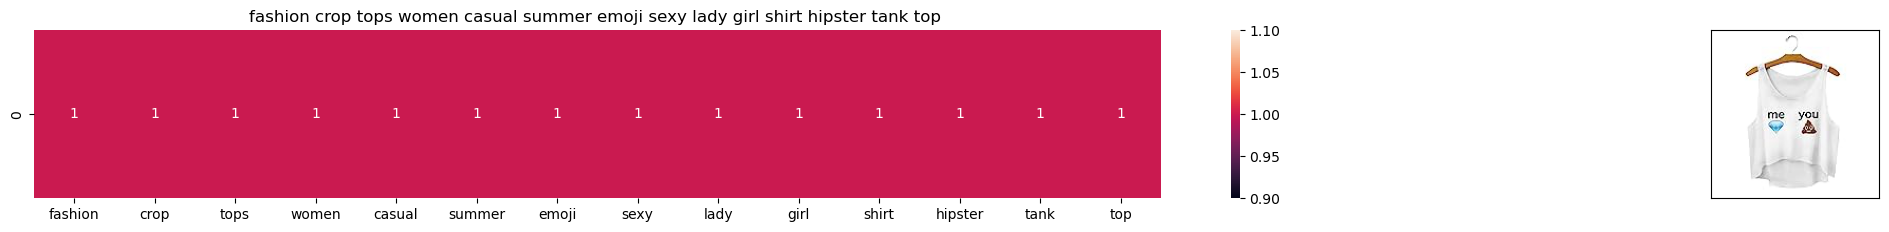

ASIN : B010V3B44G
Brand: Doxi Supermall
Title: fashion crop tops women casual summer emoji sexy lady girl shirt hipster tank top 
Euclidean similarity with the query image : 0.0


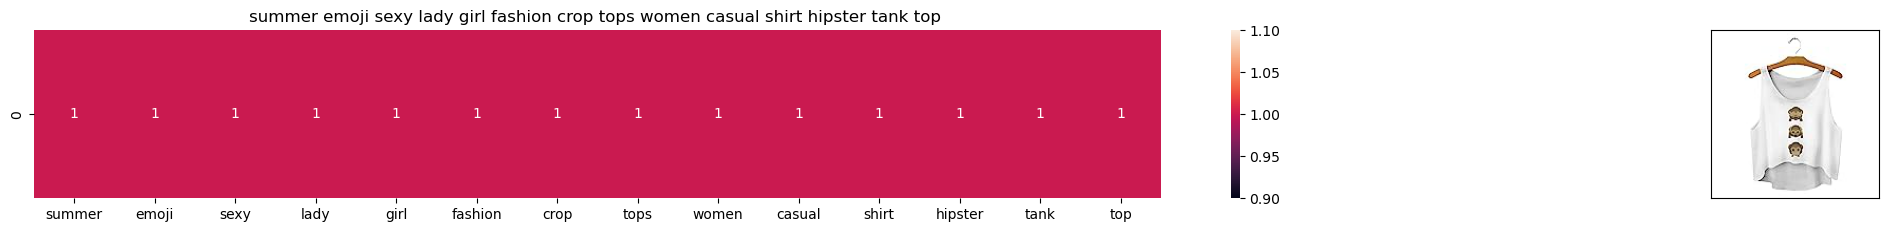

ASIN : B010V3BDII
Brand: Doxi Supermall
Title: summer emoji sexy lady girl fashion crop tops women casual shirt hipster tank top 
Euclidean similarity with the query image : 0.0


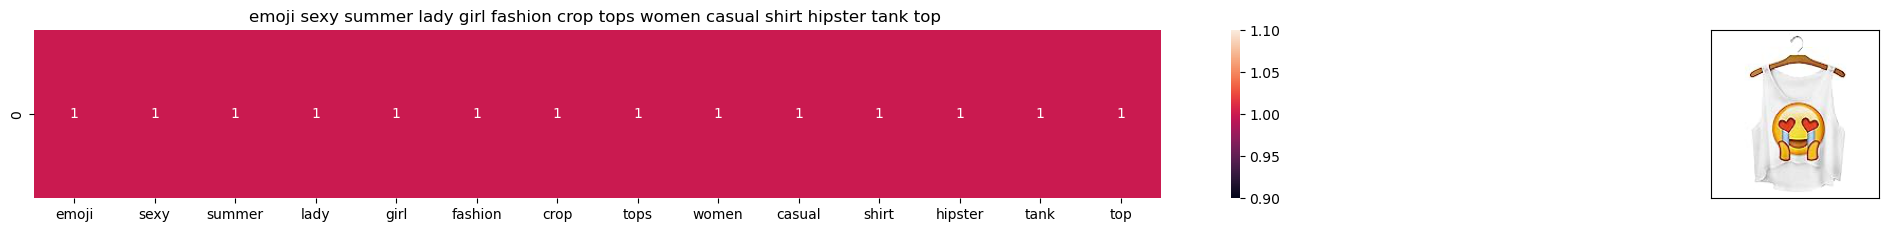

ASIN : B010V3BLWQ
Brand: Doxi Supermall
Title: emoji sexy summer lady girl fashion crop tops women casual shirt hipster tank top 
Euclidean similarity with the query image : 0.0


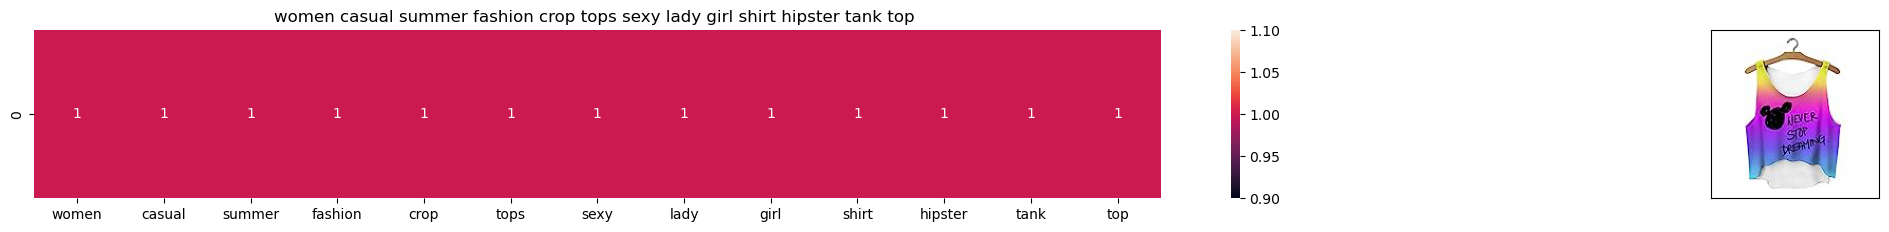

ASIN : B010V3AYSS
Brand: Doxi Supermall
Title: women casual summer fashion crop tops sexy lady girl shirt hipster tank top 
Euclidean similarity with the query image : 1.0


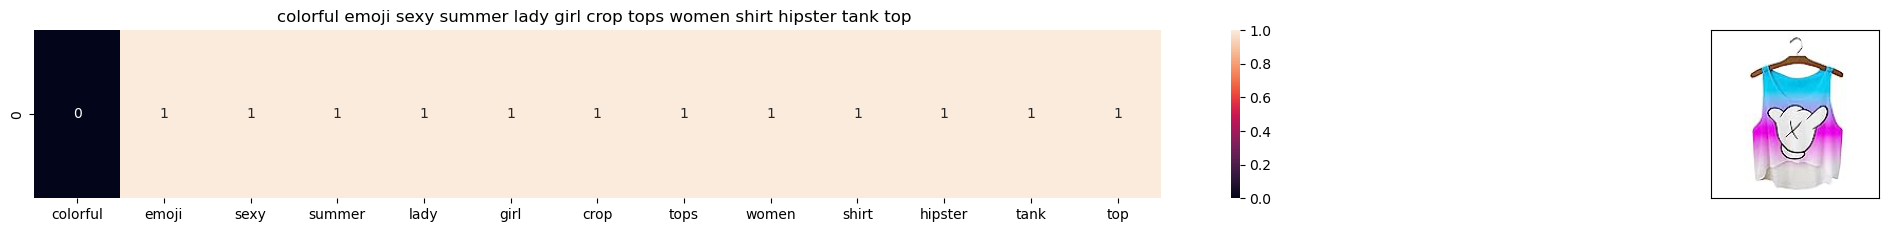

ASIN : B010V3BQZS
Brand: Doxi Supermall
Title: colorful emoji sexy summer lady girl crop tops women shirt hipster tank top 
Euclidean similarity with the query image : 1.7320508075688772


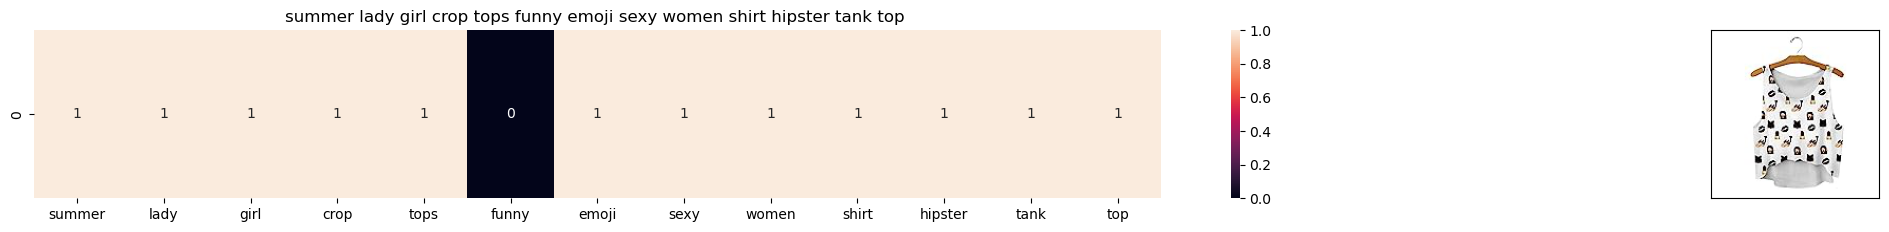

ASIN : B010V3BVMQ
Brand: Doxi Supermall
Title: summer lady girl crop tops funny emoji sexy women shirt hipster tank top 
Euclidean similarity with the query image : 1.7320508075688772


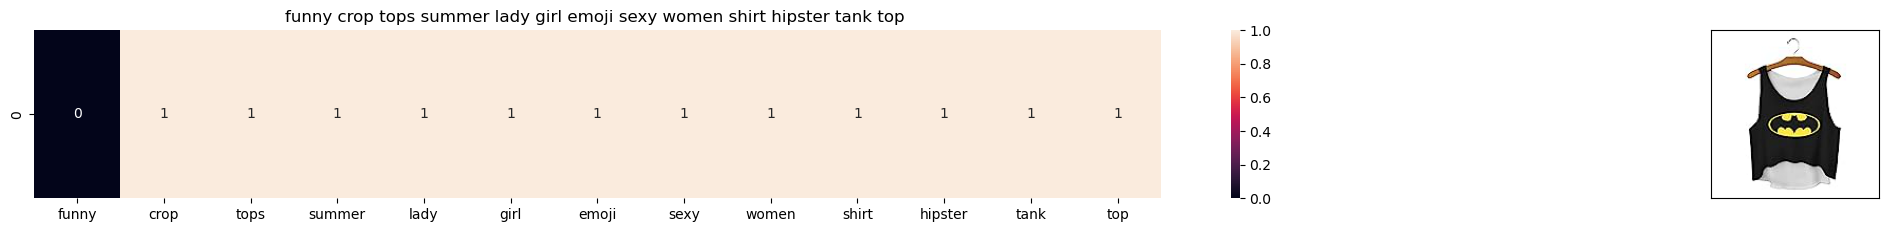

ASIN : B010V3C116
Brand: Doxi Supermall
Title: funny crop tops summer lady girl emoji sexy women shirt hipster tank top 
Euclidean similarity with the query image : 1.7320508075688772


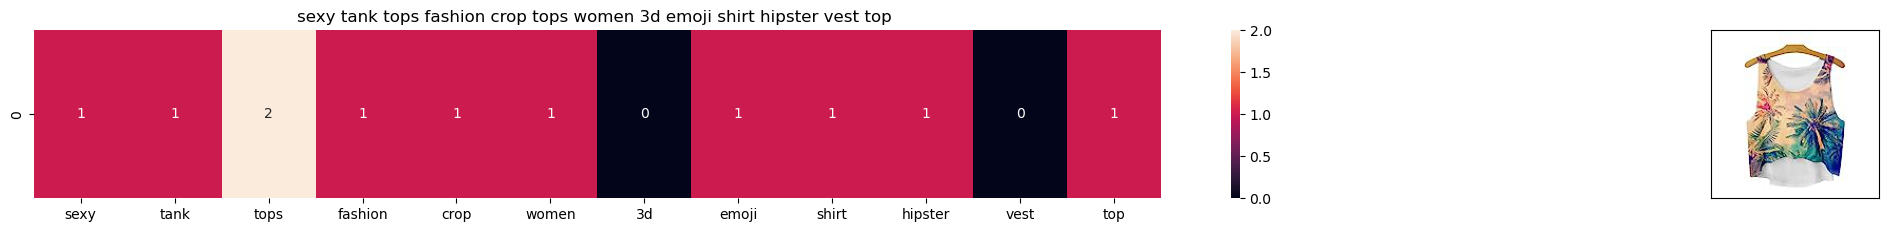

ASIN : B010V3DB9C
Brand: Doxi Supermall
Title: sexy tank tops fashion crop tops women 3d emoji shirt hipster vest top 
Euclidean similarity with the query image : 2.6457513110645907


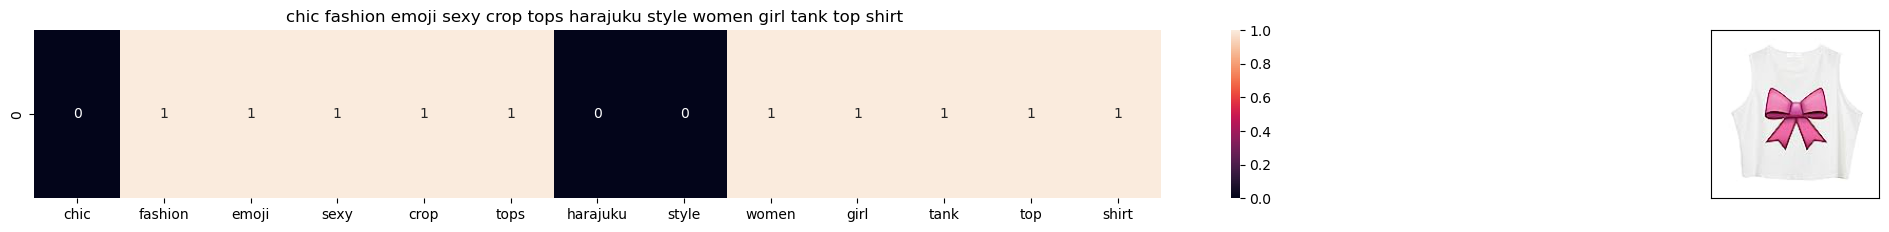

ASIN : B011RCJPR8
Brand: Chiclook Cool
Title: chic fashion emoji sexy crop tops harajuku style women girl tank top shirt 
Euclidean similarity with the query image : 2.6457513110645907


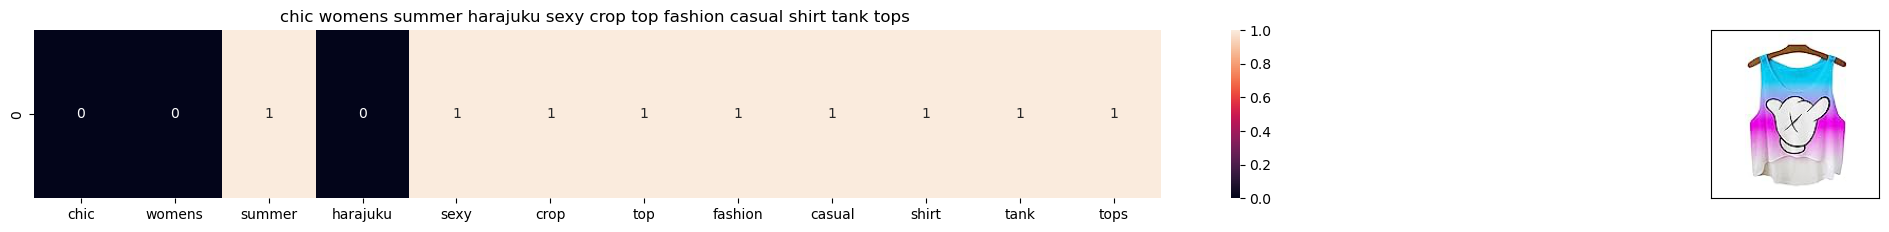

ASIN : B011RCJEMO
Brand: Chiclook Cool
Title: chic womens summer harajuku sexy crop top fashion casual shirt tank tops 
Euclidean similarity with the query image : 2.8284271247461903


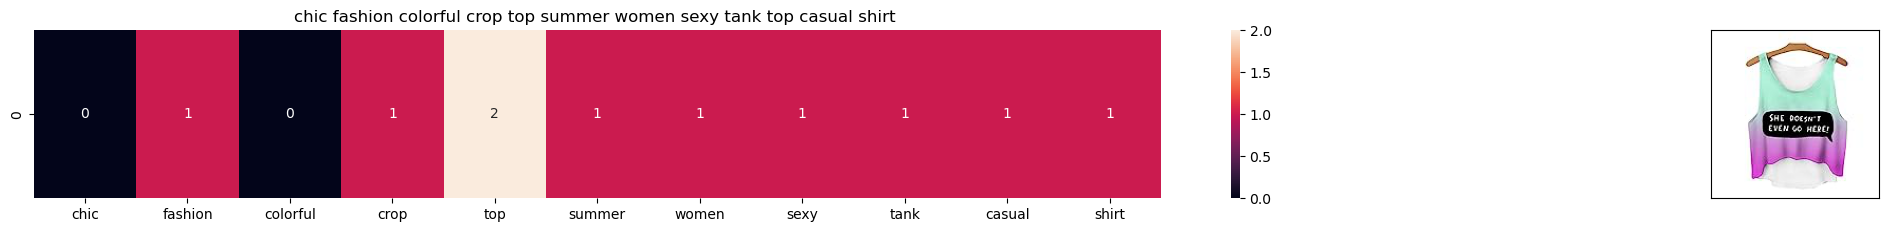

ASIN : B011RCJ6UE
Brand: Chiclook Cool
Title: chic fashion colorful crop top summer women sexy tank top casual shirt 
Euclidean similarity with the query image : 2.8284271247461903


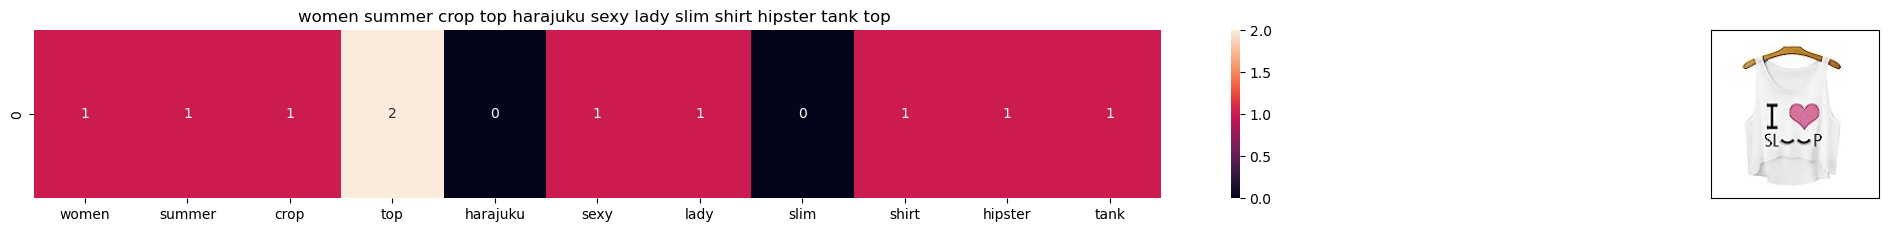

ASIN : B010V3EDEE
Brand: Doxi Supermall
Title: women summer crop top harajuku sexy lady slim shirt hipster tank top 
Euclidean similarity with the query image : 2.8284271247461903


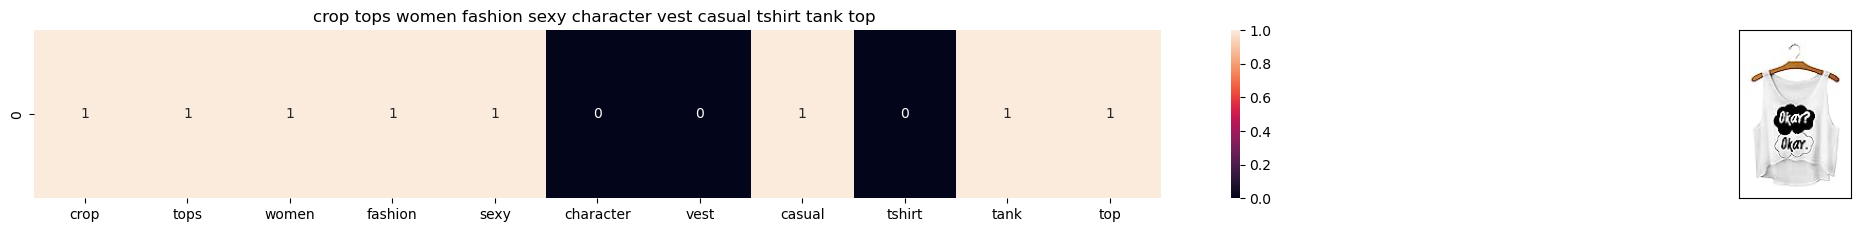

ASIN : B0107UEPVM
Brand: Mang GO
Title: crop tops women fashion sexy character vest casual tshirt tank top 
Euclidean similarity with the query image : 3.0


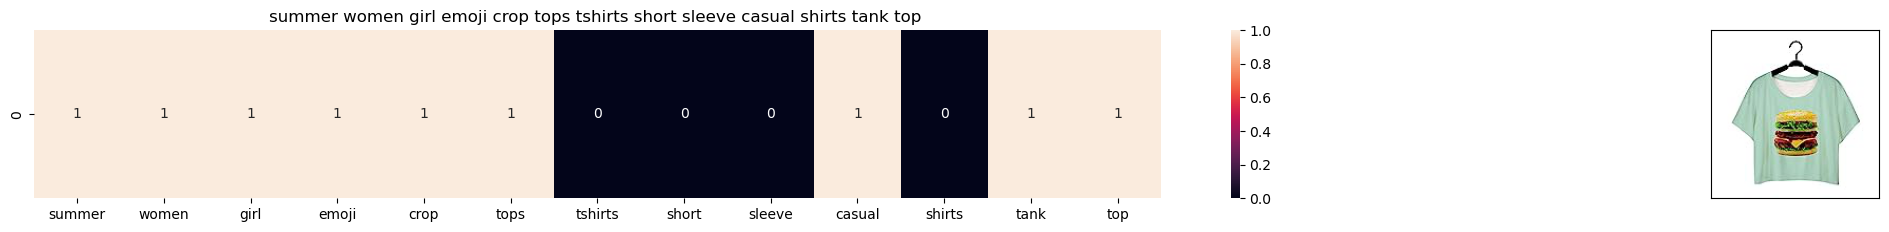

ASIN : B0124ECIU4
Brand: Doxi Supermall
Title: summer women girl emoji crop tops tshirts short sleeve casual shirts tank top 
Euclidean similarity with the query image : 3.0


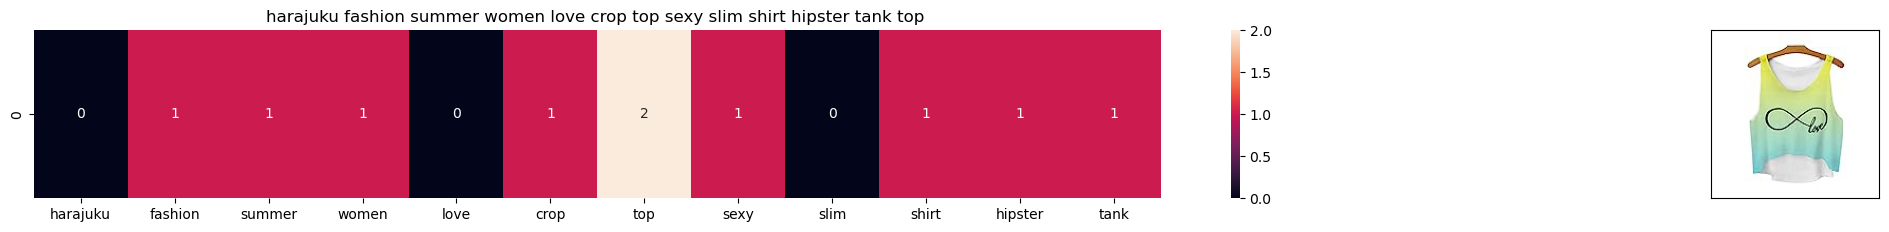

ASIN : B010V35OBU
Brand: Doxi Supermall
Title: harajuku fashion summer women love crop top sexy slim shirt hipster tank top 
Euclidean similarity with the query image : 3.0


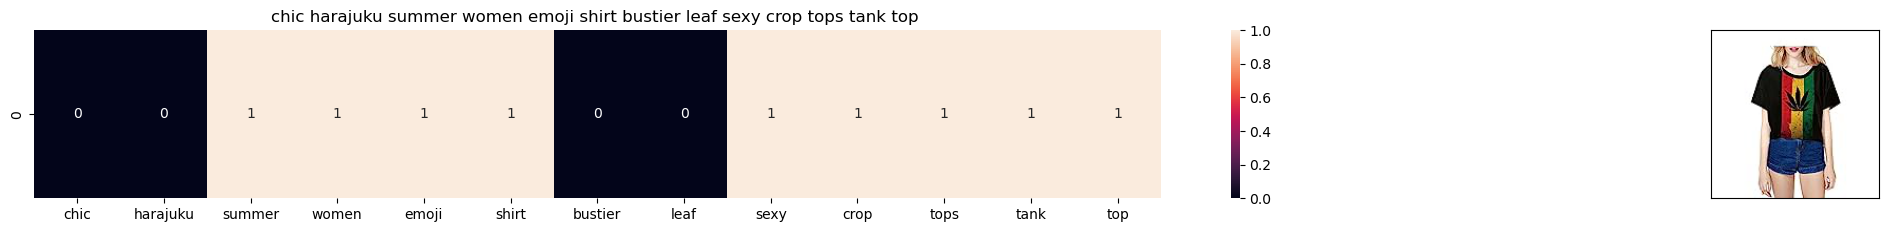

ASIN : B011UEXGH8
Brand: Chiclook Cool
Title: chic harajuku summer women emoji shirt bustier leaf sexy crop tops tank top 
Euclidean similarity with the query image : 3.0


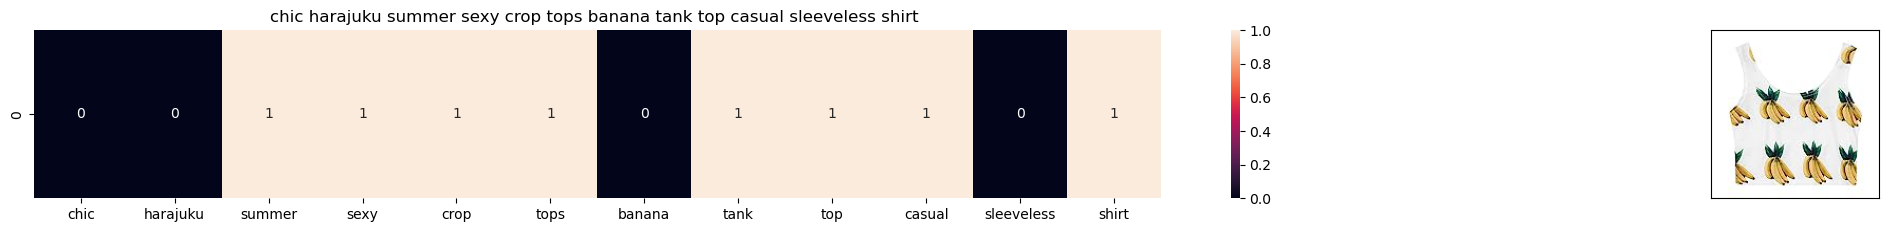

ASIN : B011RCIQBE
Brand: Chiclook Cool
Title: chic harajuku summer sexy crop tops banana tank top casual sleeveless shirt 
Euclidean similarity with the query image : 3.1622776601683795


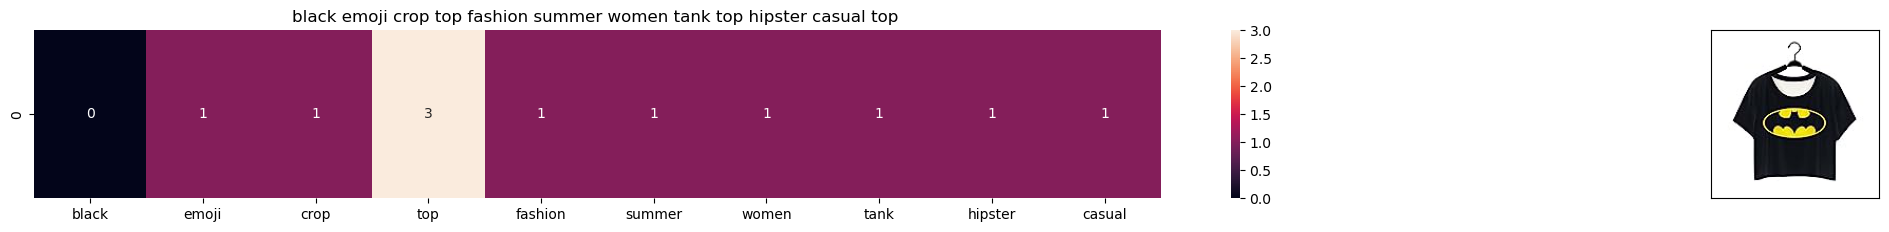

ASIN : B0124E80M4
Brand: Doxi Supermall
Title: black emoji crop top fashion summer women tank top hipster casual top 
Euclidean similarity with the query image : 3.1622776601683795


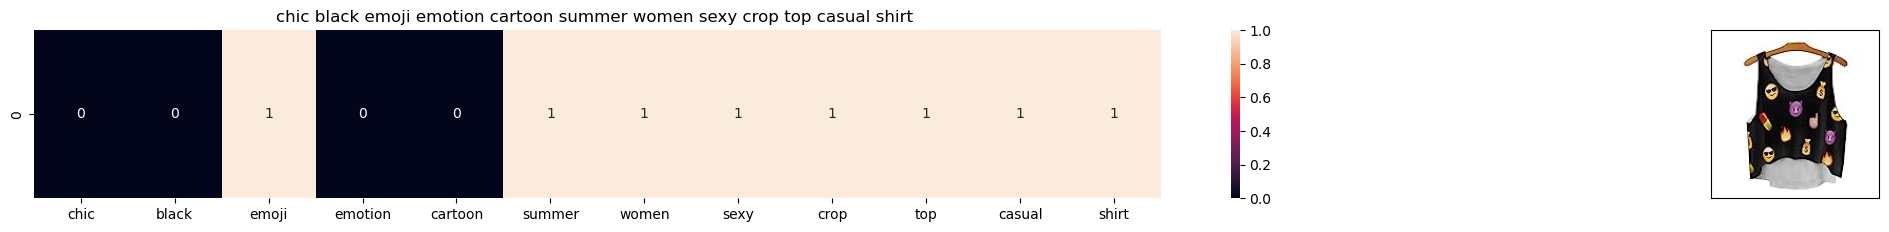

ASIN : B011RCJ4M4
Brand: Chiclook Cool
Title: chic black emoji emotion cartoon summer women sexy crop top casual shirt 
Euclidean similarity with the query image : 3.1622776601683795


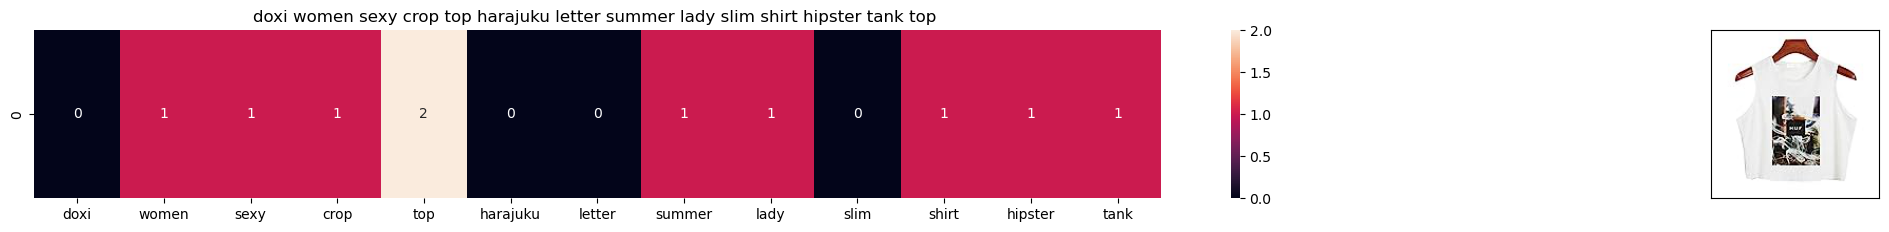

ASIN : B010V39146
Brand: Doxi Supermall
Title: doxi women sexy crop top harajuku letter summer lady slim shirt hipster tank top 
Euclidean similarity with the query image : 3.1622776601683795


In [49]:
def bag_of_words_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(title_features,title_features[doc_id])
    
    # np.argsort will return indices of the smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'bag_of_words')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print ('Brand:', data['brand'].loc[df_indices[i]])
        print ('Title:', data['title'].loc[df_indices[i]])
        print ('Euclidean similarity with the query image :', pdists[i])
        print('='*60)

#call the bag-of-words model for a product to get similar products.
bag_of_words_model(12566, 20) # change the index if you want to.
# In the output heat map each value represents the count value 
# of the label word, the color represents the intersection 
# with inputs title.

#try 12566
#try 931

our recombadation system build on two type of model
 1) bag of words 
 2) tfidf  
but as last conclusion is only it gives best recomnadation on the use of tfidf model 


## TF-IDF based product similarity

In [50]:
tfidf_title_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['title'])
# tfidf_title_features.shape = #data_points * #words_in_corpus
# CountVectorizer().fit_transform(courpus) returns the a sparase matrix of dimensions #data_points * #words_in_corpus
# tfidf_title_features[doc_id, index_of_word_in_corpus] = tfidf values of the word in given doc

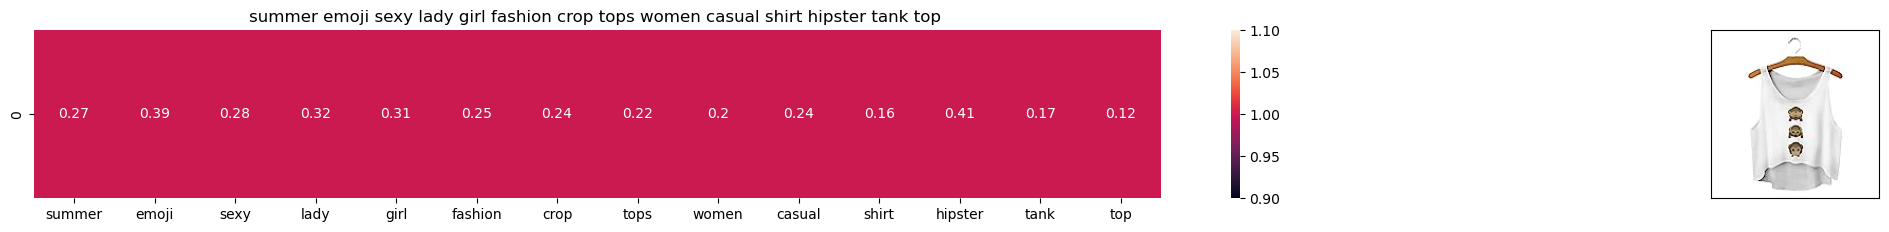

ASIN : B010V3BDII
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.0


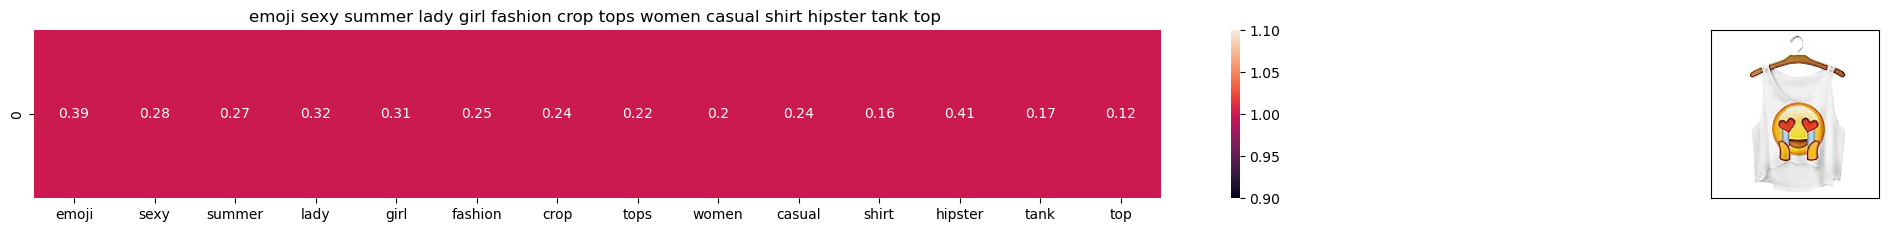

ASIN : B010V3BLWQ
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.0


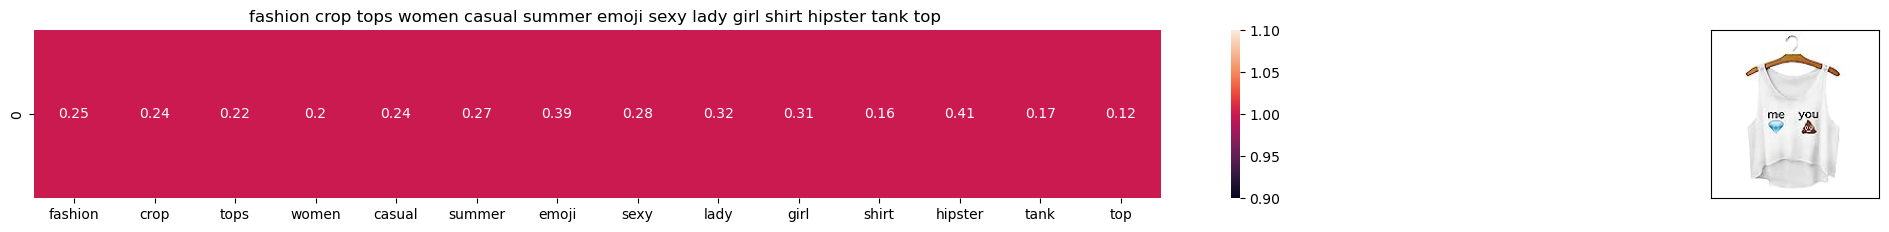

ASIN : B010V3B44G
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.0


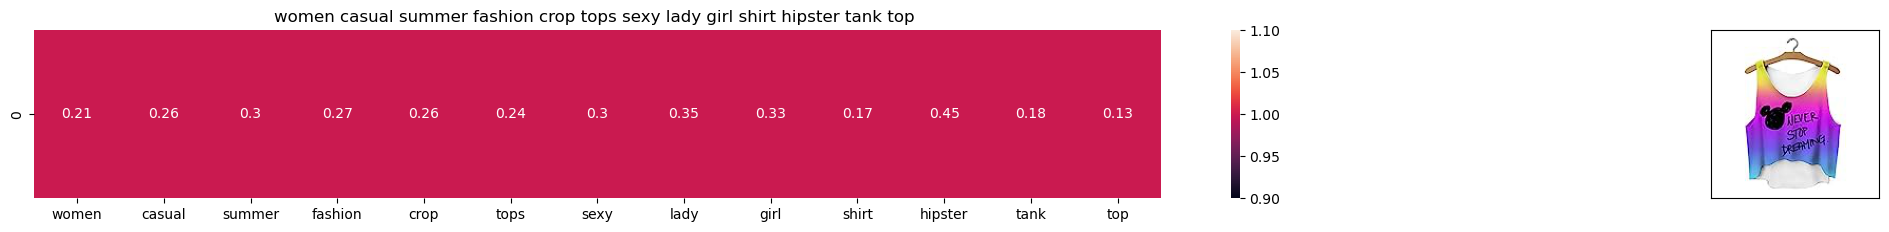

ASIN : B010V3AYSS
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.40138594750235


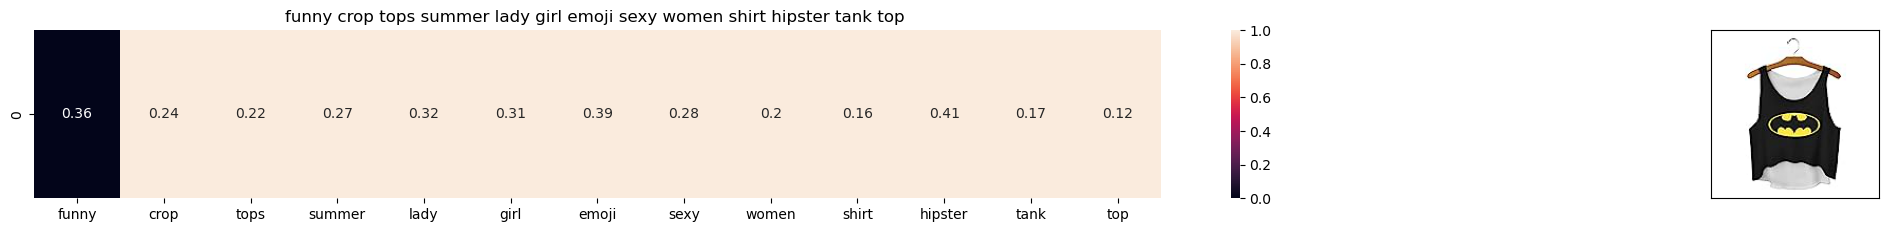

ASIN : B010V3C116
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.49544215538955555


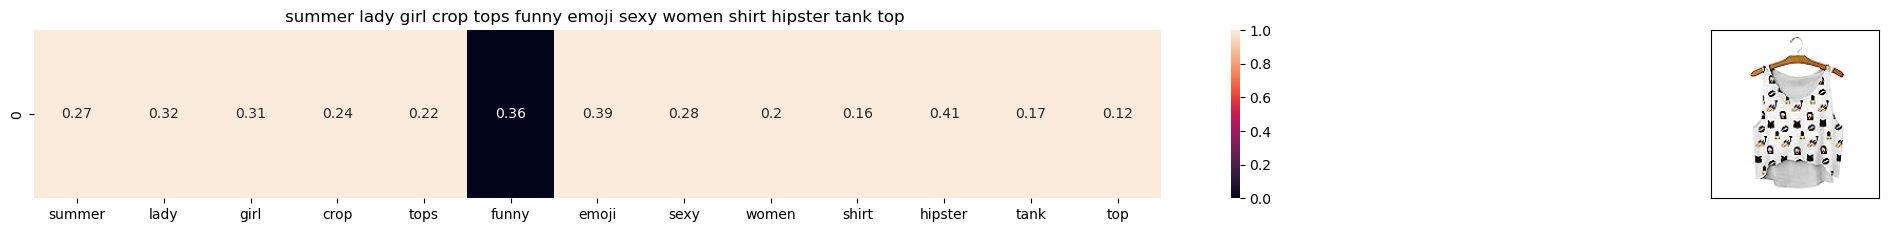

ASIN : B010V3BVMQ
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.49544215538955555


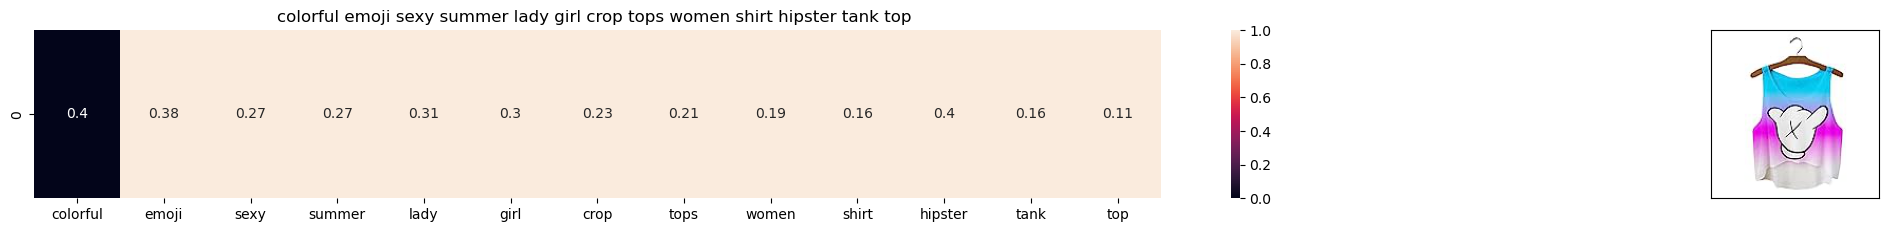

ASIN : B010V3BQZS
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.5241689140292634


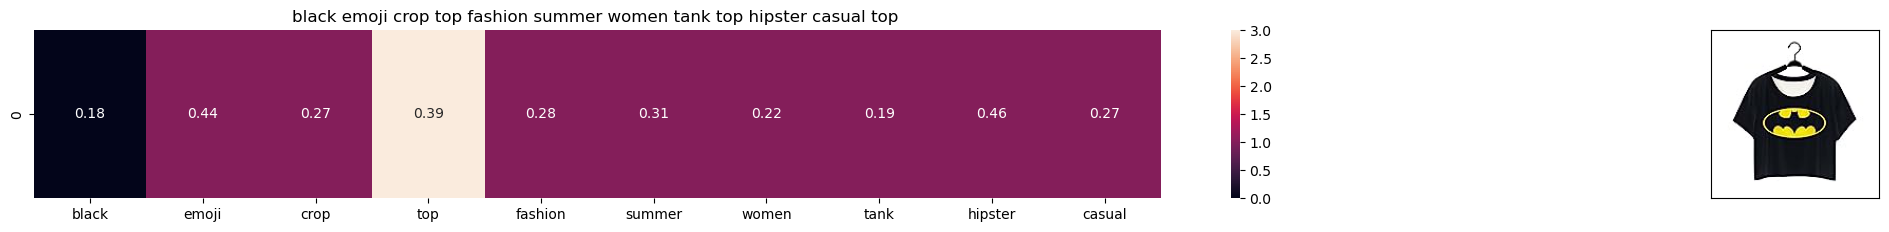

ASIN : B0124E80M4
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.684158162664275


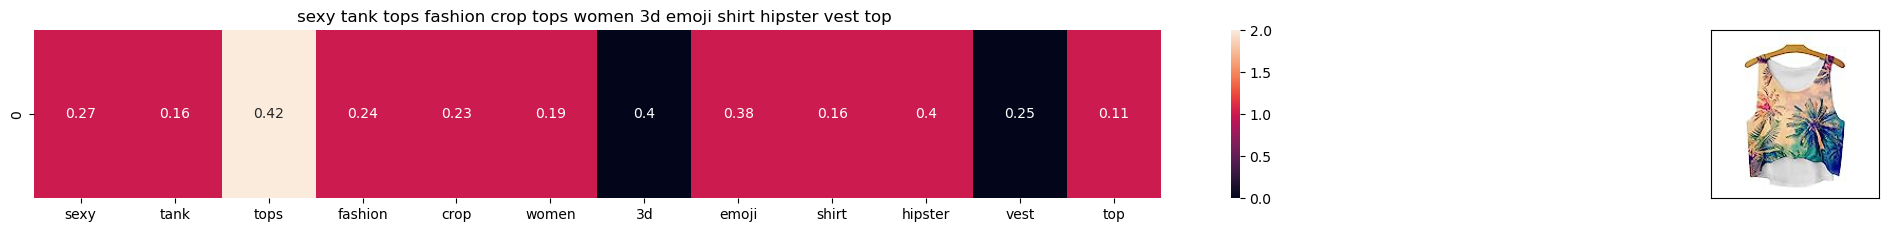

ASIN : B010V3DB9C
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.7731343455110792


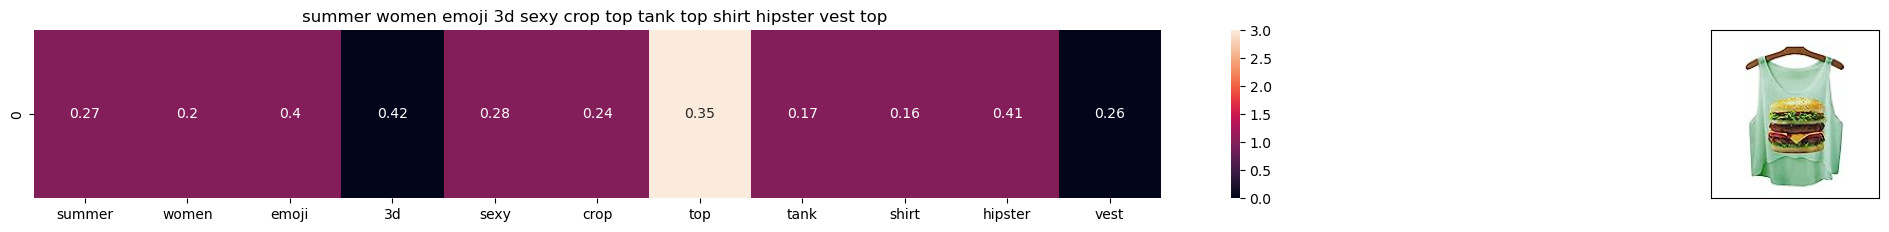

ASIN : B010V3E5EC
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.8128754313990525


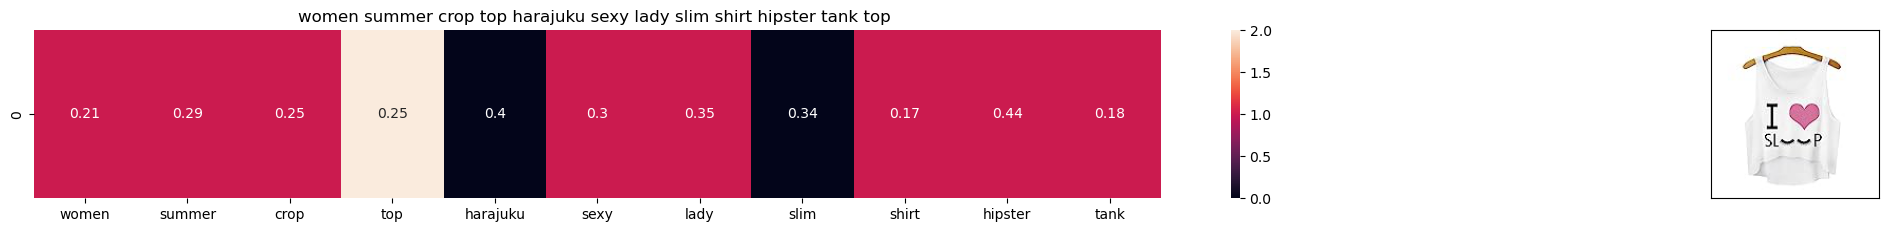

ASIN : B010V3EDEE
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.8437056912864757


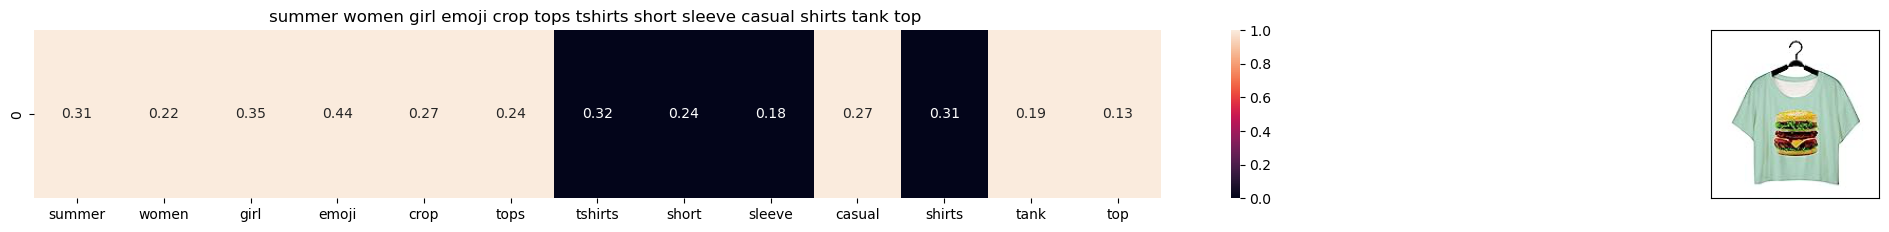

ASIN : B0124ECIU4
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.8553483954246192


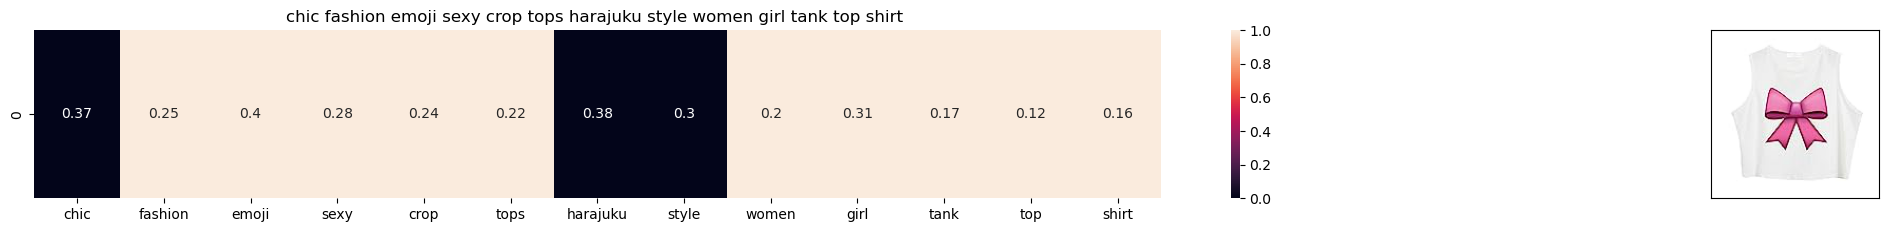

ASIN : B011RCJPR8
BRAND : Chiclook Cool
Eucliden distance from the given image : 0.8826321316686153


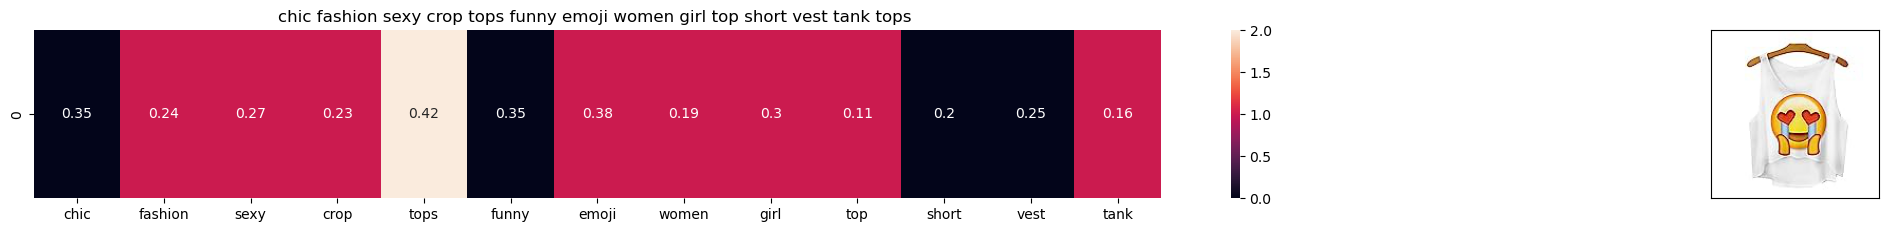

ASIN : B011RCJH58
BRAND : Chiclook Cool
Eucliden distance from the given image : 0.9004017468013861


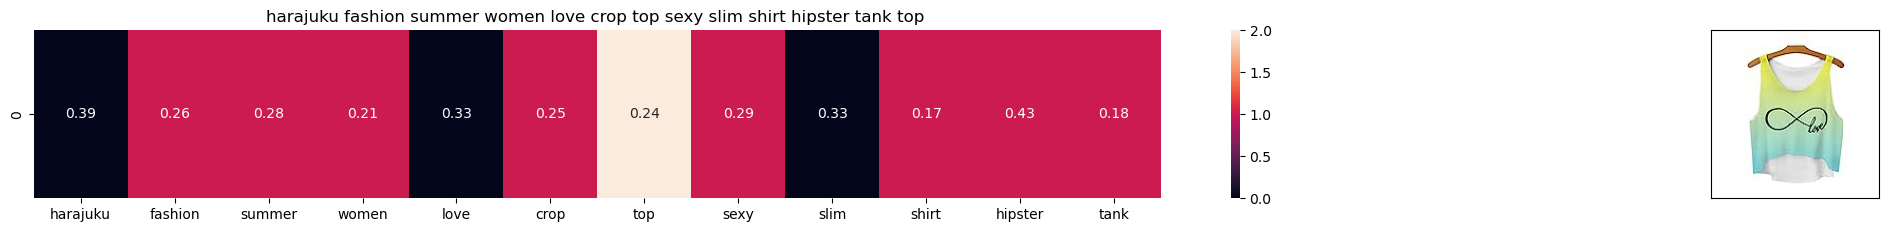

ASIN : B010V35OBU
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.9172816572673457


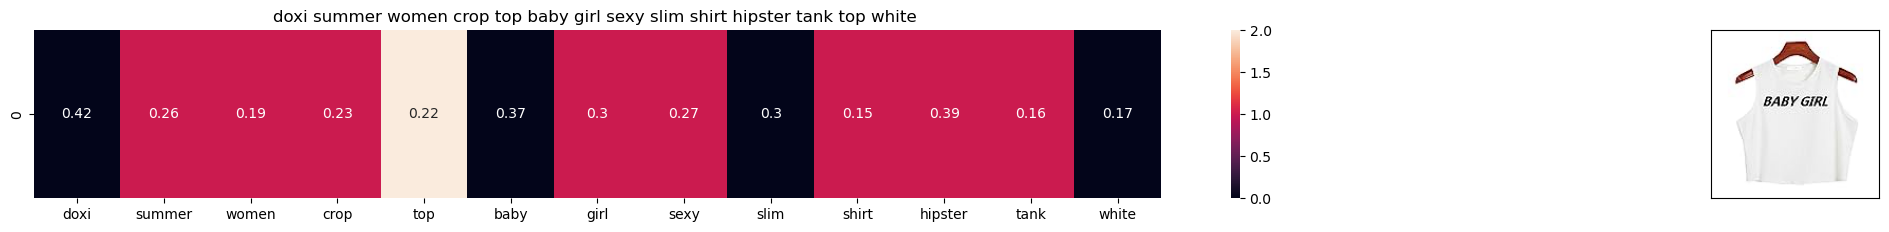

ASIN : B010V3A23U
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.9303848929561548


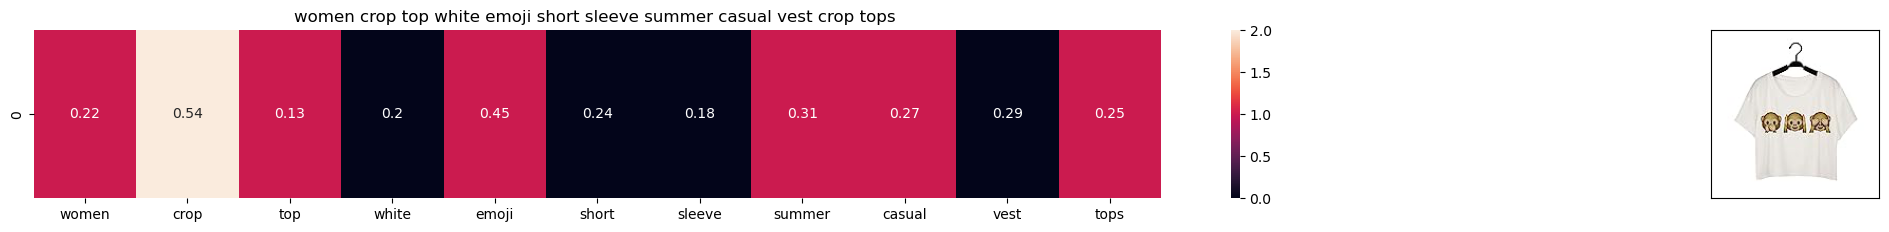

ASIN : B0124E7MHS
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.9334421080980745


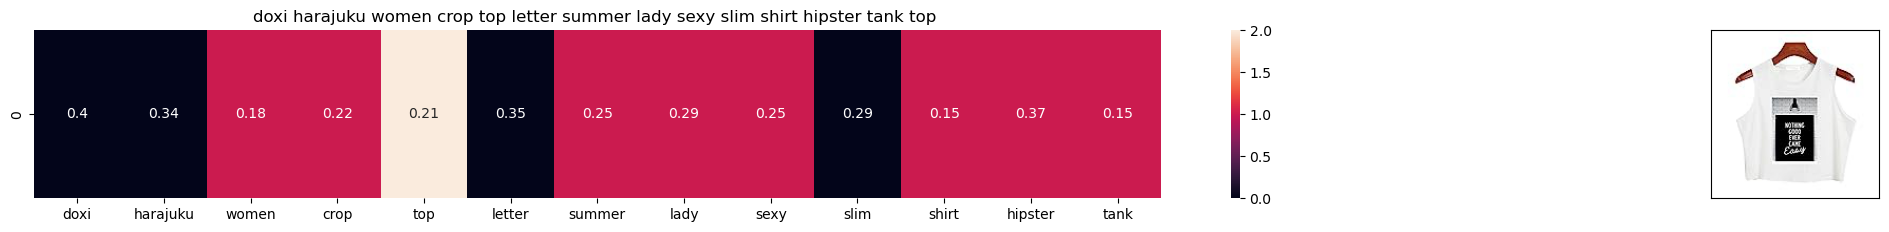

ASIN : B010V380LQ
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.9525344637195033


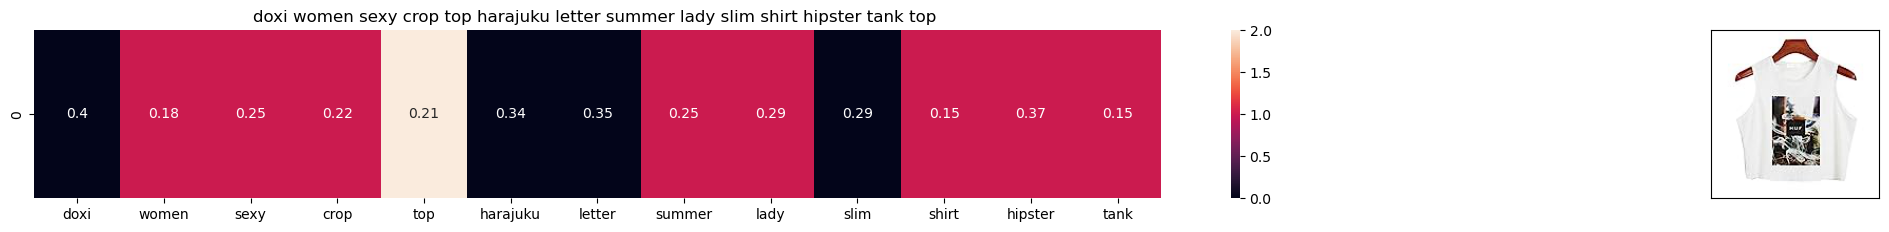

ASIN : B010V39146
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.9525344637195033


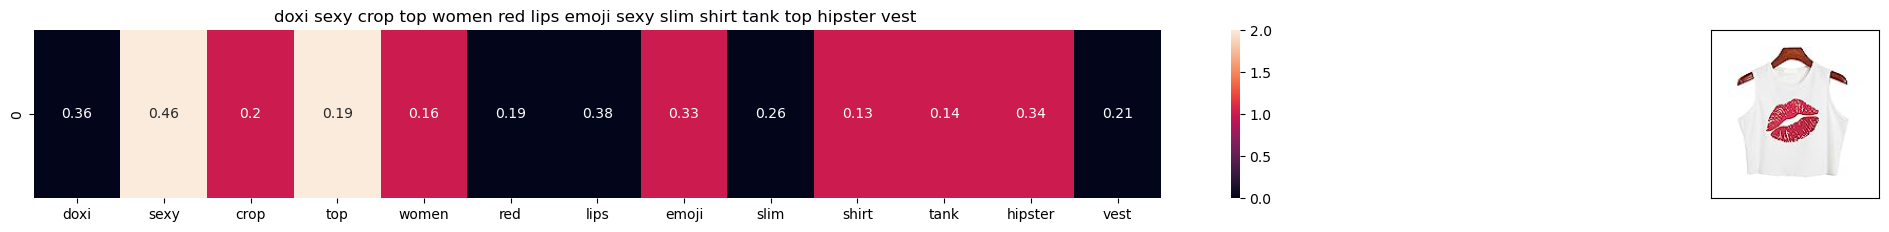

ASIN : B010TKXEHG
BRAND : Doxi Supermall
Eucliden distance from the given image : 0.9560708174154957


In [51]:
def tfidf_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(tfidf_title_features,tfidf_title_features[doc_id])

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i], data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'tfidf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print ('Eucliden distance from the given image :', pdists[i])
        print('='*125)
tfidf_model(12566, 20)
# in the output heat map each value represents the tfidf values of the label word, the color represents the intersection with inputs title